In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from matplotlib import colors as mcolors
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
color = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [2]:
hdu = fits.open('spLine_trim_dr16_eboss.fits')

In [3]:
# Defining variables
ha = hdu[1].data['H_ALPHA_FLUX'].tolist()
ha_err = hdu[1].data['H_ALPHA_FLUX_ERR'].tolist()
hb = hdu[1].data['H_BETA_FLUX'].tolist()
hb_err = hdu[1].data['H_BETA_FLUX_ERR'].tolist()
o3 = hdu[1].data['OIII_5007_FLUX'].tolist()
o3_err = hdu[1].data['OIII_5007_FLUX_ERR'].tolist()
n2 = hdu[1].data['NII_6584_FLUX'].tolist()
n2_err = hdu[1].data['NII_6584_FLUX_ERR'].tolist()

z = hdu[1].data['Z'].tolist()

In [4]:
data_names = ['ha', 'ha_err', 'hb', 'hb_err', 'n2', 'n2_err', 'o3', 'o3_err', 'z'] 
data_dict = {'ha' : ha, 'ha_err' : ha_err, 'hb' : hb, 'hb_err' : hb_err, 'n2' : n2,  'n2_err' : n2_err, 'o3' : o3, 'o3_err' : o3_err, 'z':z}
data_df = pd.DataFrame(data_dict) # A pandas dataframe is similar to a microsoft excel sheet -> easy to organize

In [5]:
for name in data_names: 
    data_df = data_df.loc[data_df[name].notnull()]

In [6]:
# Making SNR cuts
data_df = data_df.loc[(data_df['n2']/data_df['n2_err']) > 3]
data_df = data_df.loc[(data_df['ha']/data_df['ha_err']) > 3]
data_df = data_df.loc[(data_df['hb']/data_df['hb_err']) > 3]
data_df = data_df.loc[(data_df['o3']/data_df['o3_err']) > 3]

In [7]:
data_df = data_df.query('z > 0.1 & z <=0.2')

In [8]:
def bpt_kaufmann():
    x=np.linspace(-2,0,500)
    logdivline=(0.61/(x-0.05))+1.3
    return x, logdivline

def bpt_kewley():
    x=np.linspace(-2,0.46,500)
    logdivlinek=(0.61/(x-0.47))+1.19
    return x, logdivlinek

def bpt_liner():
    x=np.linspace(-0.133638005,0.75,100)
    y=2.1445*x+0.465
    return x,y

def agn_classification_line1():
    x = np.linspace(-2, 0, 500)
    y = (0.61/(x-0.02-0.1833*(data_df.loc[:,"z"].median())))+1.2+0.03*(data_df.loc[:,"z"].median())
    return x, y

def z_zero_kewl_line():
    x = np.linspace(-2, 0, 500)
    y = 0.61/(x-0.02)+1.2
    return x, y

In [15]:
def density_scatter(x, y, ax, color_map, sort = True, bins = 1000, **kwargs):

    data, x_e, y_e = np.histogram2d(x, y, bins = bins, density = True)
    z = interpn((0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1])), data, np.vstack([x, y]).T, method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]


    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    ax.scatter(x, y, c=z, cmap = color_map, **kwargs, label=None)
#    cbar = plt.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
#    cbar.ax.set_ylabel('Density')

    return ax

In [16]:
def density_scatter2(x2, y2, ax2, color_map, sort = True, bins = 1000, **kwargs):

    data2, x_e2, y_e2 = np.histogram2d(x2, y2, bins = bins, density = True)
    z2 = interpn((0.5*(x_e2[1:] + x_e2[:-1]), 0.5*(y_e2[1:]+y_e2[:-1])), data2, np.vstack([x2, y2]).T, method = "splinef2d", bounds_error = False)

    z2[np.where(np.isnan(z2))] = 0.0

    if sort:
        idx = z2.argsort()
        x2, y2, z2 = x2[idx], y2[idx], z2[idx]

    norm2 = Normalize(vmin = np.min(z2), vmax = np.max(z2))
    ax2.scatter(x2, y2, c=z2, cmap = color_map, **kwargs, label=None)

    return ax2

In [17]:
def density_scatter3(x3, y3, ax3, color_map, sort = True, bins = 1000, **kwargs):

    data3, x_e3, y_e3 = np.histogram2d(x3, y3, bins = bins, density = True)
    z3 = interpn((0.5*(x_e3[1:] + x_e3[:-1]), 0.5*(y_e3[1:]+y_e3[:-1])), data3, np.vstack([x3,y3]).T, method = "splinef2d", bounds_error = False)

    z3[np.where(np.isnan(z3))] = 0.0

    if sort:
        idx = z3.argsort()
        x3, y3, z3 = x3[idx], y3[idx], z3[idx]

    norm3 = Normalize(vmin = np.min(z3), vmax = np.max(z3))
    ax3.scatter(x3, y3, c=z3, cmap = color_map, **kwargs, label=None)

    return ax3

In [18]:
def plot_bpt(df):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.style.use('grayscale')

    df_groups = df.groupby(['colors']) 
    
    for name, group in df_groups:

        if name == 'starform':
            color_map = 'Purples'
        elif name == 'agn':
            color_map = 'Greys'
        elif name == 'low-metallicity-agn':
            color_map = 'Reds'

        halpha = group.ha.values
        nii = group.n2.values
        hbeta = group.hb.values
        oiii = group.o3.values
        halpha2 = group.ha.values
        nii2 = group.n2.values
        hbeta2 = group.hb.values
        oiii2 = group.o3.values
        halpha3 = group.ha.values
        nii3 = group.n2.values
        hbeta3 = group.hb.values
        oiii3 = group.o3.values

        colors = group.colors

        n2ha=np.log10(nii/halpha)
        o3hb=np.log10(oiii/hbeta)
        ax_1 = density_scatter(n2ha, o3hb, ax, color_map = color_map)
        n2ha2=np.log10(nii2/halpha2)
        o3hb2=np.log10(oiii2/hbeta2)
        ax_2 = density_scatter2(n2ha2, o3hb2, ax, color_map = color_map)
        n2ha3=np.log10(nii3/halpha3)
        o3hb3=np.log10(oiii3/hbeta3)
        ax_3 = density_scatter3(n2ha3, o3hb3, ax, color_map = color_map)
    
    z_zero=z_zero_kewl_line()
    agn_class=agn_classification_line1()
    agn_0=ax.plot(z_zero[0],z_zero[1],c='coral', linestyle='--')
    agn=ax.plot(agn_class[0],agn_class[1],c='b')
    mix=ax.plot([-0.466, 0.003], [-0.408, 0.979], c='r')
    
    ax.set_xlim(-2.0,0.75)
    ax.set_ylim(-1.25,1.75)
    ax.set_title('Median Z~0.143 -- Universe 11.7 Gyr Old')
    ax.legend(['z=0 Kewley Line', 'z=0.143 Kewley Line', 'Thomas Mixing Sequence', 'AGNs (N=4852)', 'Low Metallicity AGNs (N=153)', 'Star Forming (N=6093)'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax = plt.gca()
    leg = ax.get_legend()
    leg.legendHandles[4].set_color('red')
    leg.legendHandles[5].set_color('purple')
    ax.set_xlabel(r'$log_{10}($[NII]/h$\alpha)$')
    ax.set_ylabel(r'$log_{10}($[OIII]/h$\beta)$')
    plt.show()
    return

In [19]:
def assign_color(df):
    x_values = df.x.values
    y_values = df.y.values.tolist()

    kewl_agn_class_line = (0.61/(x_values-0.02-0.1833*(data_df.loc[:,"z"].median())))+1.2+0.03*(data_df.loc[:,"z"].median())
    
    color_list = []

    for x, y, agn_line in zip(x_values, y_values, kewl_agn_class_line):
        if x < -0.8 and y > agn_line:
            color_list.append('low-metallicity-agn')
        elif x >=-0.8 and y > agn_line:
            color_list.append('agn')
        elif x > 0.0:
            color_list.append('agn')                                                                              
        else:
            color_list.append('starform')

    df['colors'] = color_list

    return df

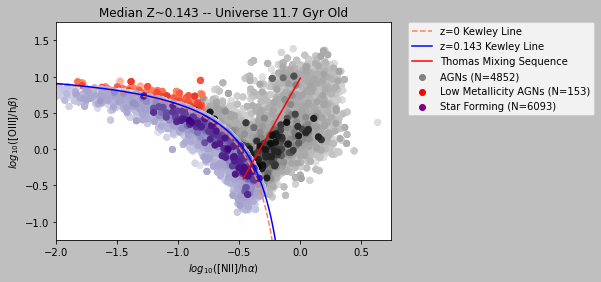

In [20]:
data_df['x'] = np.log10(data_df['n2']/data_df['ha'])
data_df['y'] = np.log10(data_df['o3']/data_df['hb'])

data_df = assign_color(data_df)

plot_bpt(data_df)